## Part 1. Build a Basic Chatbot

Start by creating a `StateGraph`.  
A `StateGraph` object defines the structure of our chatbot as a "state machine". 
We'll add `nodes` to represent the llm and functions our chatbot can call and `edges` to specify how the bot should transition between these functions.

In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    # Messages have the type "list". 
    # The `add_messages` function in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

When defining a graph, the first step is to define its State. The `State` includes the graph's schema and reducer functions that handle state updates. In our example, `State` is a `TypedDict` with one key: `messages`. The `add_messages` reducer function is used to append new messages to the list instead of overwriting it. Keys without a reducer annotation will overwrite previous values.

Next, add a "`chatbot`" node. Nodes represent units of work. They are typically regular python functions.

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

Add an entry point. This tells our graph **where to start its work** each time we run it.

In [3]:
graph_builder.add_edge(START, "chatbot")

Similarly, set a `finish` point. This instructs the graph "**any time this node is run, you can exit.**"

In [4]:
graph_builder.add_edge("chatbot", END)

Finally, we'll want to be able to run our graph. To do so, call "`compile()`" on the graph builder. This creates a "`CompiledGraph`" we can use invoke on our state.

In [5]:
graph = graph_builder.compile()

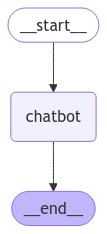

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [7]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_update(user_input)
    except:
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  hi


User: What do you know about LangGraph?
Assistant: As of my last update in October 2023, LangGraph is a framework designed for building applications that utilize language models, particularly in the context of natural language processing (NLP). It enables developers to create complex workflows and applications that can integrate various language processing capabilities. 

LangGraph typically allows for the integration of different components such as data sources, preprocessing steps, model inference, and post-processing in a structured way, often using a graph-based architecture. This approach can facilitate better organization, scalability, and modularity in developing language-based applications.

The framework may also provide tools for managing prompts, handling model outputs, and combining multiple models or APIs to achieve desired results. It is particularly useful for tasks like text generation, summarization, translation, and other NLP applications.

For the most accurate and d

## Part 2: 🛠️ Enhancing the Chatbot with Tools

To handle queries our chatbot can't answer "from memory", we'll integrate a web search tool. Our bot can use this tool to find relevant information and provide better responses.

In [8]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'Nodes¶ In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id). Similar to NetworkX, you add these nodes to a graph using the add_node method:'},
 {'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making'}]

Next, we'll start defining our graph.   
The following is all **the same as in Part 1**, except we have added `bind_tools` on our LLM. This lets the LLM know the correct JSON format to use if it wants to use our search engine.

In [9]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI

from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, we implement a `BasicToolNode` that checks the most recent message in the state and calls tools if the message contains `tool_calls`. It relies on the LLM's `tool_calling` support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

We will later replace this with LangGraph's prebuilt `ToolNode` to speed things up, but building it ourselves first is instructive.

In [10]:
import json

from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dump(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

With the tool node added, we can define the `conditional_edges`.  

The condition will route to `tools` if tool calls are present and `END` if not.

Later, we will replace this with the prebuilt `tools_condition` to be more concise, but implementing it ourselves first makes things more clear.

In [11]:
from typing import Literal

def route_tools(state: State):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile()

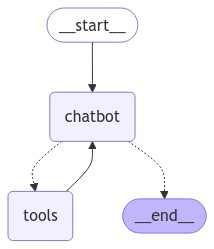

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  What training data did you use to train you?


Assistant: I was trained on a diverse range of text data from books, websites, and other texts to develop a wide-ranging understanding of human language. This includes information on various topics, but I don't have access to my training data, and it wasn't sourced from specific databases or documents. My training involved processing and learning patterns in language to generate coherent and contextually relevant responses.


User:  q


Goodbye!


Our chatbot still can't remember past interactions on its own, limiting its ability to have coherent, multi-turn conversations. In the next part, we'll add memory to address this.

## Part 3: Adding Memory to the Chatbot

Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem through **persistent checkpointing**. If you provide a `checkpointer` when compiling the graph and a `thread_id` when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same `thread_id`, the graph loads its saved state, allowing the chatbot to pick up where it left off.

We will see later that **checkpointing** is much more powerful than simple chat memory - it lets you save and resume complex state at any time for error recovery, human-in-the-loop workflows, time travel interactions, and more. But before we get too ahead of ourselves, let's add checkpointing to enable multi-turn conversations.

In [8]:
# To get started, create a MemorySaver checkpointer.

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

**Notice** we're using an in-memory checkpointer. This is convenient for our tutorial (it saves it all in-memory). In a production application, you would likely change this to use `SqliteSaver` or `PostgresSaver` and connect to your own DB.

In [9]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage

from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")

In [10]:
graph = graph_builder.compile(checkpointer=memory)

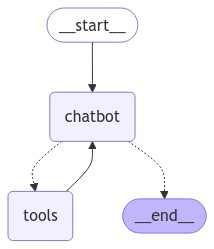

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
# pick a thread to use as the key for this conversation
config = {"configurable": {"thread_id": "1"}}

In [13]:
user_input = "Hi there! My name is Jiyun."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Jiyun.
================================== Ai Message ==================================

Hello, Jiyun! How can I assist you today?


**Note**: The config was provided as the **second positional argument** when calling our graph. It importantly is not nested within the graph inputs ({'`messages`': []}).

In [15]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is Jiyun. How can I assist you further?


In [16]:
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I don't have the ability to remember personal information or previous interactions. However, you can remind me of your name or any other details you'd like me to know!


By now, we have made a few checkpoints across two different threads. But what goes into a checkpoint? To inspect a graph's `state` for a given config at any time, call `get_state(config)`.

In [17]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Jiyun.', additional_kwargs={}, response_metadata={}, id='eb1b62a7-9724-4f86-a854-18f66f4958fd'), AIMessage(content='Hello, Jiyun! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 89, 'total_tokens': 103, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'stop', 'logprobs': None}, id='run-4e0e4117-1574-4410-95a9-b6e333c5a641-0', usage_metadata={'input_tokens': 89, 'output_tokens': 14, 'total_tokens': 103, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Remember my name?', additional_kwar

In [19]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

## Part 4: Human-in-the-loop

Agents can be unreliable and may need human input to successfully accomplish tasks. Similarly, for some actions, you may want to require human approval before running to ensure that everything is running as intended.

LangGraph supports `human-in-the-loop` workflows in a number of ways. In this section, we will use LangGraph's `interrupt_before` functionality to always break the tool node.

First, start from our existing code. The following is copied from Part 3.

In [26]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

memory = MemorySaver()

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool_node = ToolNode(tools=[tool])

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
    
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
graph_builder.add_edge("tools", "chatbot")

In [27]:
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"]
)

In [28]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_VPVl4dRzsYnubw5hACkoDgDt)
 Call ID: call_VPVl4dRzsYnubw5hACkoDgDt
  Args:
    query: LangGraph


In [30]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

Notice that unlike last time, the "next" node is set to 'tools'. We've interrupted here! Let's check the tool invocation.



In [32]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph'},
  'id': 'call_VPVl4dRzsYnubw5hACkoDgDt',
  'type': 'tool_call'}]

Next, continue the graph! Passing in `None` will just let the graph continue where it left off, without adding anything new to the state.

In [33]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_VPVl4dRzsYnubw5hACkoDgDt)
 Call ID: call_VPVl4dRzsYnubw5hACkoDgDt
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a low-level framework that allows you to create stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph with LangChain, LangSmith, and Anthropic tools to build agent and multi-agent workflows."}, {"url": "https://academy.langchain.com/courses/intro-to-langgraph", "content": "Separate from the LangChain package, LangGraph helps developers add better precision and control into agentic workflows. Lesson 1: Motivation Lesson 2: Simple Graph Lesson 3: LangGraph Studio Lesson 4: Chain Lesson 5: Router Lesson 6: Agent L

## Part 5: Manually Updating the State

In [34]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool_node = ToolNode(tools)

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

memory = MemorySaver()

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
    
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
graph_builder.add_edge("tools", "chatbot")

graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"]
)

In [35]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [36]:
snapshot = graph.get_state(config)

existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_flYFhkRgRQ7gENn6nNH0Quls)
 Call ID: call_flYFhkRgRQ7gENn6nNH0Quls
  Args:
    query: LangGraph programming language


So far, all of this is an exact repeat of the previous section. The LLM just requested to use the search engine tool and our graph was interrupted. If we proceed as before, the tool will be called to search the web.

But what if the user wants to intercede? What if we think the chat bot doesn't need to use the tool?

Let's directly provide the correct response!

In [37]:
from langchain_core.messages import AIMessage, ToolMessage

answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)

new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]
new_messages[-1].pretty_print()

graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages}
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


Last 2 messages;
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='b4934ed4-cf42-4468-83be-19184ff0a43b', tool_call_id='call_flYFhkRgRQ7gENn6nNH0Quls'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={}, id='38da1e85-2248-4a09-a321-eb0e2737f592')]


We annotated `messages` with the pre-built `add_messages` function. This instructs the graph to always append values to the existing list, rather than overwriting the list directly. The same logic is applied here, so the messages we passed to `update_state` were appended in the same way!

The `update_state` function operates as if it were one of the nodes in your graph! By default, the update operation uses the node that was last executed, but you can manually specify it below. Let's add an update and tell the graph to treat it as if it came from the "chatbot".

In [38]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb20af-3e14-6d6e-8003-84ef2e6d3f11'}}

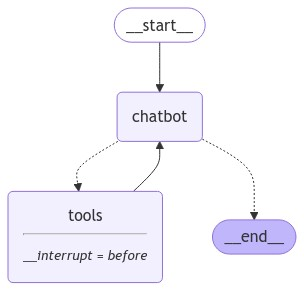

In [39]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [40]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='b4934ed4-cf42-4468-83be-19184ff0a43b', tool_call_id='call_flYFhkRgRQ7gENn6nNH0Quls'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={}, id='38da1e85-2248-4a09-a321-eb0e2737f592'), AIMessage(content="I'm an AI expert!", additional_kwargs={}, response_metadata={}, id='4a1e1f1e-d5ad-4778-a1d4-12cb616d7199')]
()


**What if you want to overwrite existing messages?**

let's update the tool invocation to make sure we get good results from our search engine! First, start a new thread:

In [44]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "2"}}

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_8SDYplwDpELAQIhwuvA42zcL)
 Call ID: call_8SDYplwDpELAQIhwuvA42zcL
  Args:
    query: LangGraph programming language


Next, let's update the tool invocation for our agent. Maybe we want to search for human-in-the-loop workflows in particular.


In [46]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])

Original
Message ID run-626adec0-d1cd-4d66-b3a7-d3f092658884-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph programming language'}, 'id': 'call_8SDYplwDpELAQIhwuvA42zcL', 'type': 'tool_call'}


In [47]:
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': 'call_8SDYplwDpELAQIhwuvA42zcL', 'type': 'tool_call'}
Message ID run-626adec0-d1cd-4d66-b3a7-d3f092658884-0


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': 'call_8SDYplwDpELAQIhwuvA42zcL',
  'type': 'tool_call'}]

In [48]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_8SDYplwDpELAQIhwuvA42zcL)
 Call ID: call_8SDYplwDpELAQIhwuvA42zcL
  Args:
    query: LangGraph human-in-the-loop workflow
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.youtube.com/watch?v=9BPCV5TYPmg", "content": "In this video, I'll show you how to handle persistence with LangGraph, enabling a unique Human-in-the-Loop workflow. This approach allows a human to grant an"}, {"url": "https://medium.com/@kbdhunga/implementing-human-in-the-loop-with-langgraph-ccfde023385c", "content": "In this article, we will explore how the human-in-the-loop mechanism works in LangGraph with a simple example. In this example, we introduce a breakpoint before the tools are executed (action) to"}]
================================== Ai Message ==================================

I found some r

All of this is reflected in the graph's checkpointed memory, meaning if we continue the conversation, it will recall all the modified state.

In [49]:
events = graph.stream(
    {
        "messages": (
            "user",
            "Remember what I'm learning about?",
        )
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember what I'm learning about?
================================== Ai Message ==================================

You're learning about LangGraph, specifically focusing on its human-in-the-loop workflow.


## Part 6: Customizing State

In [50]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    ask_human: bool

In [51]:
# Define a schema to show the model to let it decide to request assistance
from pydantic import BaseModel

class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str

In [53]:
tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = ChatOpenAI(model="gpt-4o-mini")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])

def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

In [54]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

In [55]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"]
    )

def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        "messages": new_messages,
        "ask_human": False,
    }

graph_builder.add_node("human", human_node)

In [56]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    return tools_condition(state)

graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END}
)

In [57]:
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()

graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"]
)

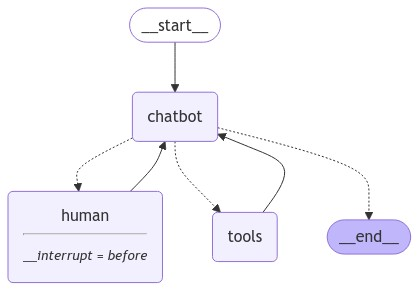

In [58]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [59]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [("user", user_input)]},
    config,
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (call_5vcHvDR2E2JBGlduEmsLiIeu)
 Call ID: call_5vcHvDR2E2JBGlduEmsLiIeu
  Args:
    request: I need expert guidance on building an AI agent. I'm looking for advice on architecture, tools, and best practices.


In [60]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

In [62]:
ai_message = snapshot.values["messages"][-1]

human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb29d7-538e-64da-8002-9f51540e21e0'}}

In [63]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='7cce83d6-ee38-4190-9008-2f597ffba2ee'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5vcHvDR2E2JBGlduEmsLiIeu', 'function': {'arguments': '{"request":"I need expert guidance on building an AI agent. I\'m looking for advice on architecture, tools, and best practices."}', 'name': 'RequestAssistance'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 160, 'total_tokens': 197, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bfe0a40d-423a-4190-a2a

In [64]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    print(event)
    if "messages" in event:
        event["messages"][-1].pretty_print()

{'messages': [HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='7cce83d6-ee38-4190-9008-2f597ffba2ee'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5vcHvDR2E2JBGlduEmsLiIeu', 'function': {'arguments': '{"request":"I need expert guidance on building an AI agent. I\'m looking for advice on architecture, tools, and best practices."}', 'name': 'RequestAssistance'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 160, 'total_tokens': 197, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0705bf87c0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bfe0a40d-4

## Part 7: Time Travel

In [68]:
from pydantic import BaseModel

from typing import Annotated, Literal
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, ToolMessage

from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o-mini")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

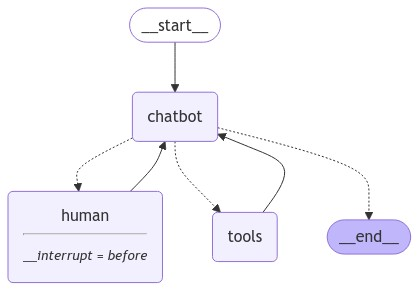

In [69]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [70]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "I'm learning LangGraph. Could you do some research on it for me?")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_H8OO3MtHHBPZhA2Y2d8IOIat)
 Call ID: call_H8OO3MtHHBPZhA2Y2d8IOIat
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agent large language model (LLM) applications. Learn how to use LangGraph to create stateful, flexible, and scalable systems with nodes, edges, and state management."}, {"url": "https://github.com/langchain-ai/langgraph", "content": "GitHub - langchain-ai/langgraph: Build resilient language agents as graphs. LangGraph Platform is a 

In [71]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it!")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That sounds like an exciting project! Building an autonomous agent using LangGraph can open up many possibilities for creating intelligent applications. You can explore various functionalities like decision-making, state management, and integrating external tools to enhance your agent's capabilities.

If you need any more assistance or resources as you work on your project, feel free to ask. Good luck with your development!


In [74]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 2:
        to_replay = state

Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


In [75]:
print(to_replay.next)
print(to_replay.config)

('tools',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efb2a0a-1e8c-6f1b-8001-801cba7e0b9b'}}


In [76]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_H8OO3MtHHBPZhA2Y2d8IOIat)
 Call ID: call_H8OO3MtHHBPZhA2Y2d8IOIat
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agent large language model (LLM) applications. Learn how to use LangGraph to create stateful, flexible, and scalable systems with nodes, edges, and state management."}, {"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a low-level framework that allows you to create stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph with LangChain, LangSmith, and Anthropic tools to build agent and